# **Working memory training**: Supplementary statistical analyses of training-related changes of brain activity in preselected networks




In [4]:
# Loading packages
library(psych)
library(tidyverse)
library(data.table)
library(nlme)
library(broom)
library(Hmisc)

# Customizing theme for plotting
theme_training <- theme_bw() + theme(axis.text.y = element_text(size=25, colour='#262626ff'),
          axis.text.x = element_text(size=25, colour='#262626ff'),
          axis.title.y = element_text(size=25, colour='#262626ff'),
          axis.title.x  = element_text(size=25, colour='#262626ff'),
          plot.title = element_text(hjust=0.5, size=25),
          panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour="#262626ff"),
          panel.border = element_rect(colour = "#262626ff", fill=NA, size=1.8),
          panel.background = element_rect(fill="transparent",colour=NA),
          plot.background = element_rect(fill="transparent",colour=NA),
          legend.key = element_rect(fill= "transparent", colour="transparent"),
          strip.background =element_rect(fill="transparent", colour=NA),
          strip.text = element_text(size=25),
          axis.ticks = element_line(colour="#262626ff", size=1, 2),
          axis.ticks.length = unit(.15, "cm"),
          aspect.ratio = 1,
          )

In [5]:
# Setting working directory
setwd("~/Dropbox/Projects/LearningBrain/")

glm <- read.csv('data/neuroimaging/04-glm/glm_results.csv')
glm$Session <- factor(glm$Session, levels = c('Naive', 'Early', 'Middle', 'Late'))

high_motion <- c('sub-13', 'sub-21', 'sub-23', 'sub-50')
glm <- glm %>% filter(!(Subject %in% high_motion))
unique_networks <- unique(glm$Network)

### Multilevel modeling for each large-scale system

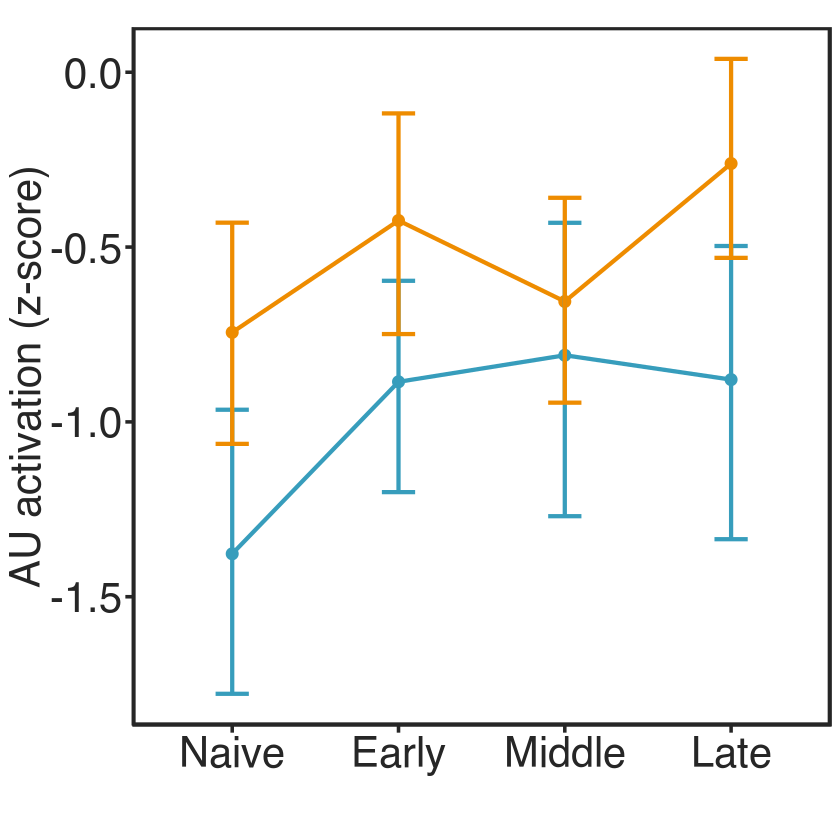

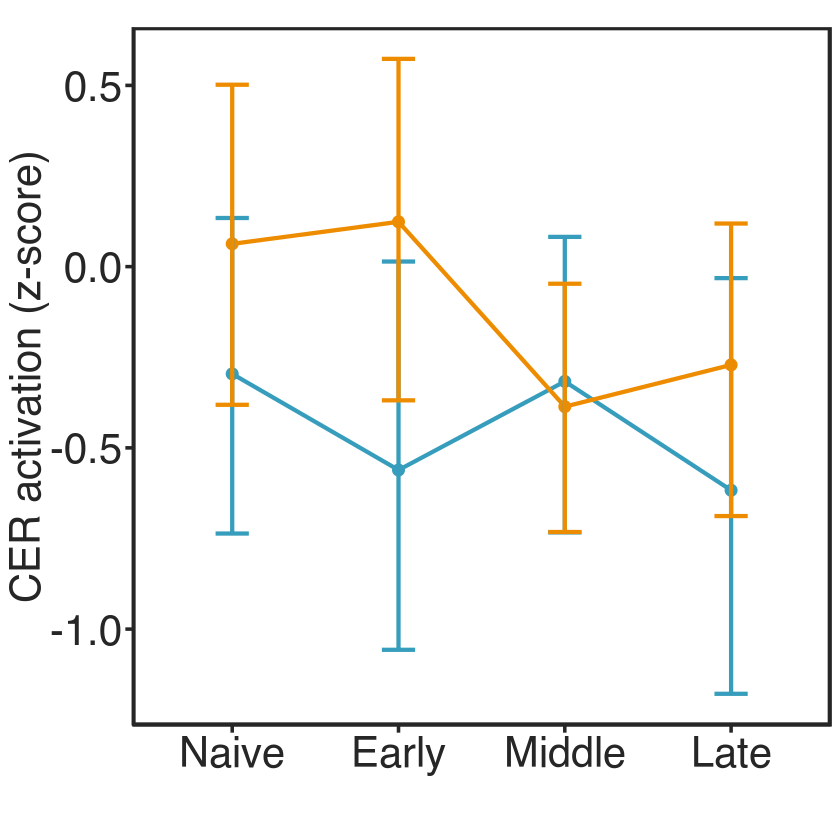

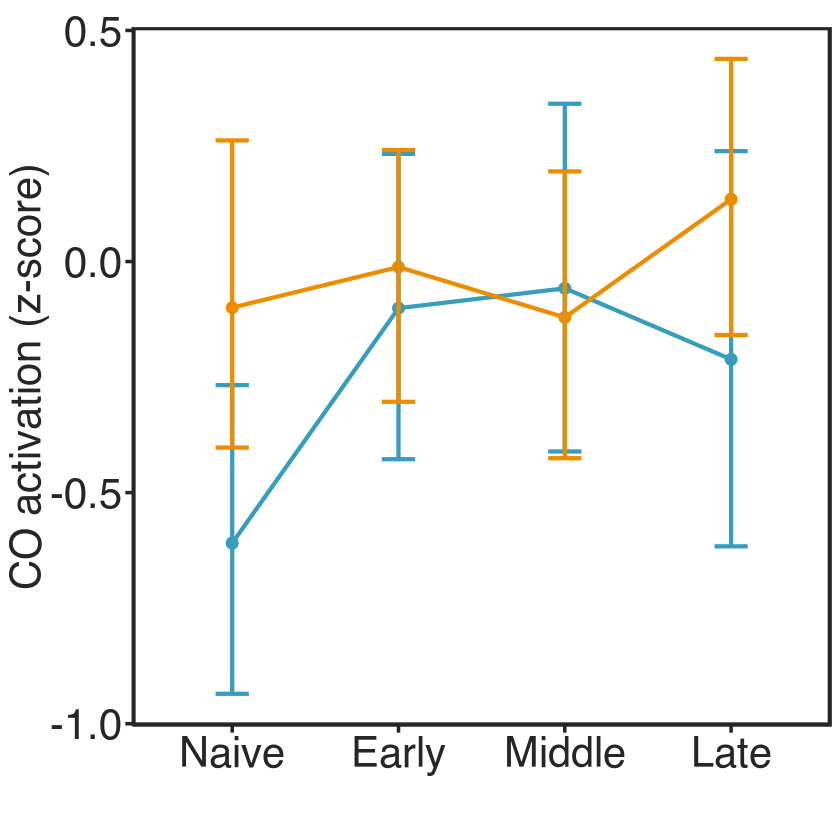

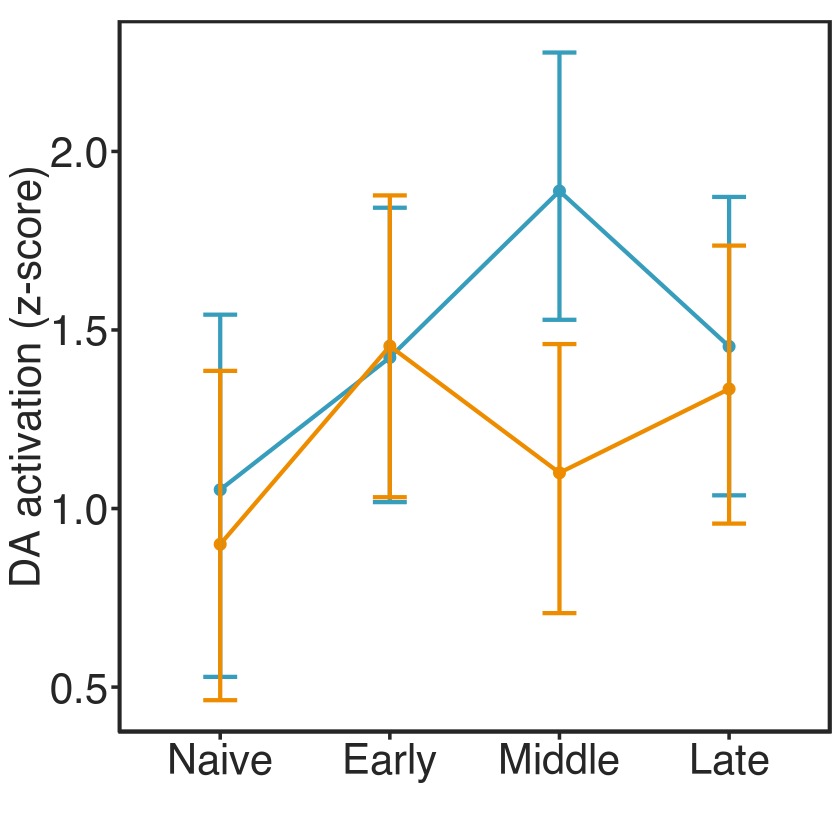

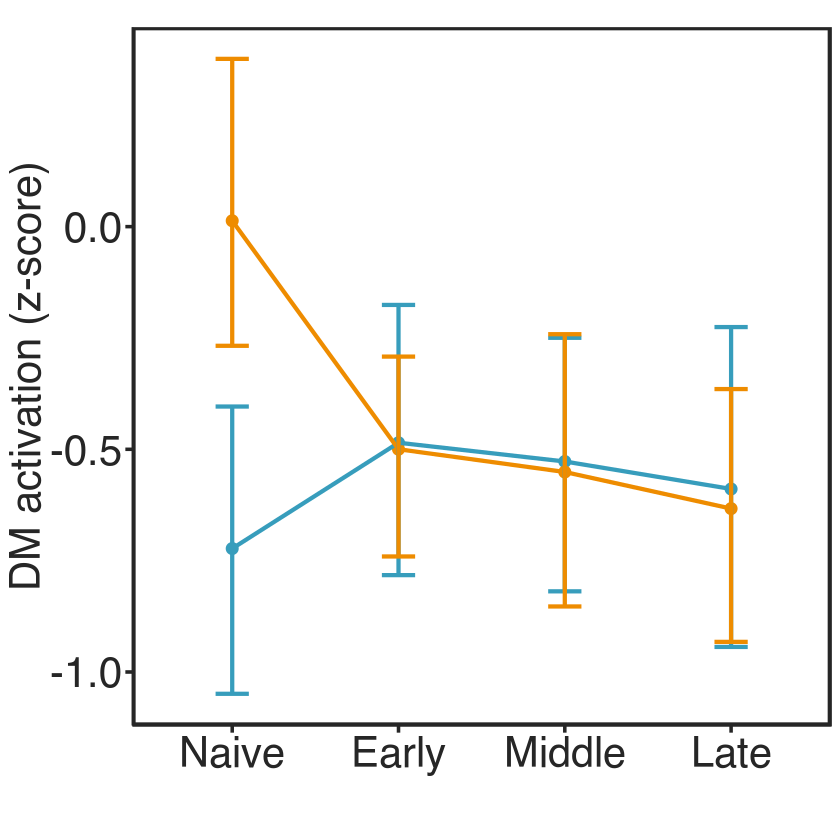

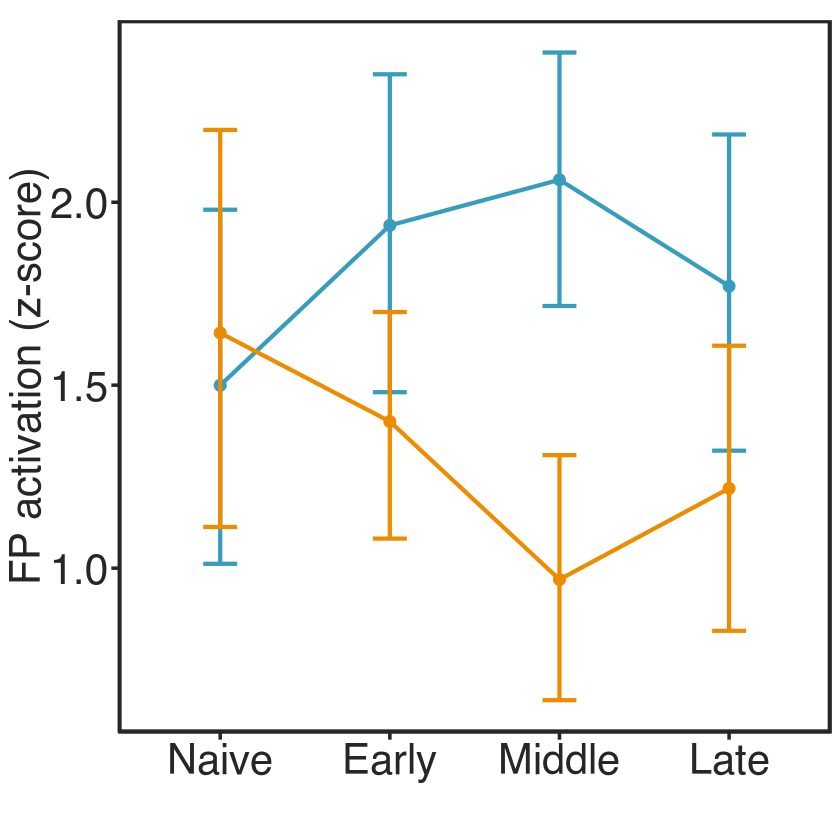

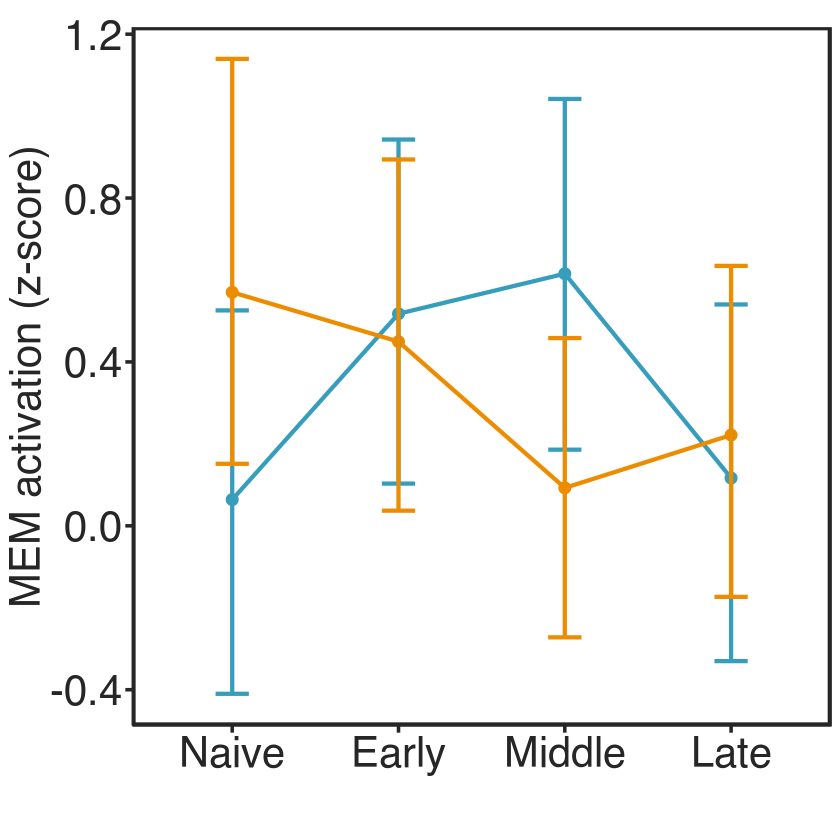

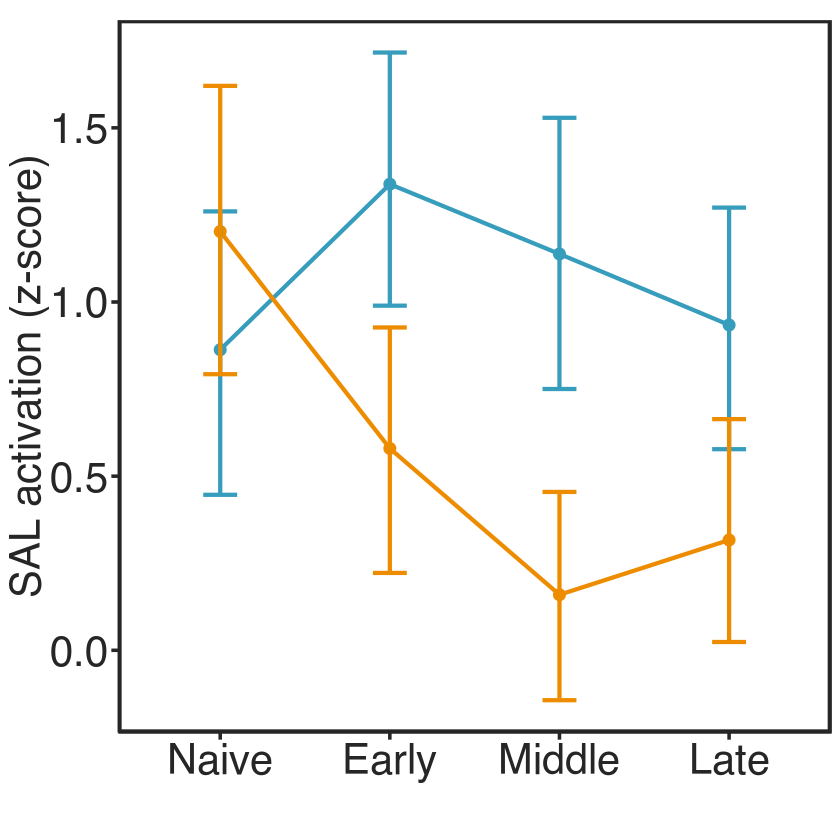

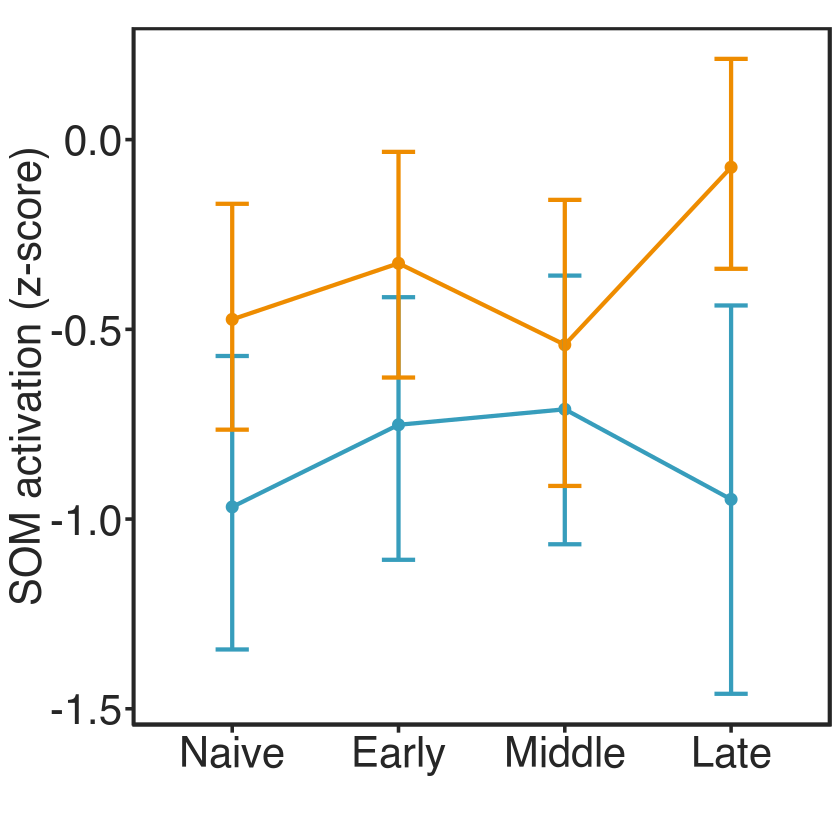

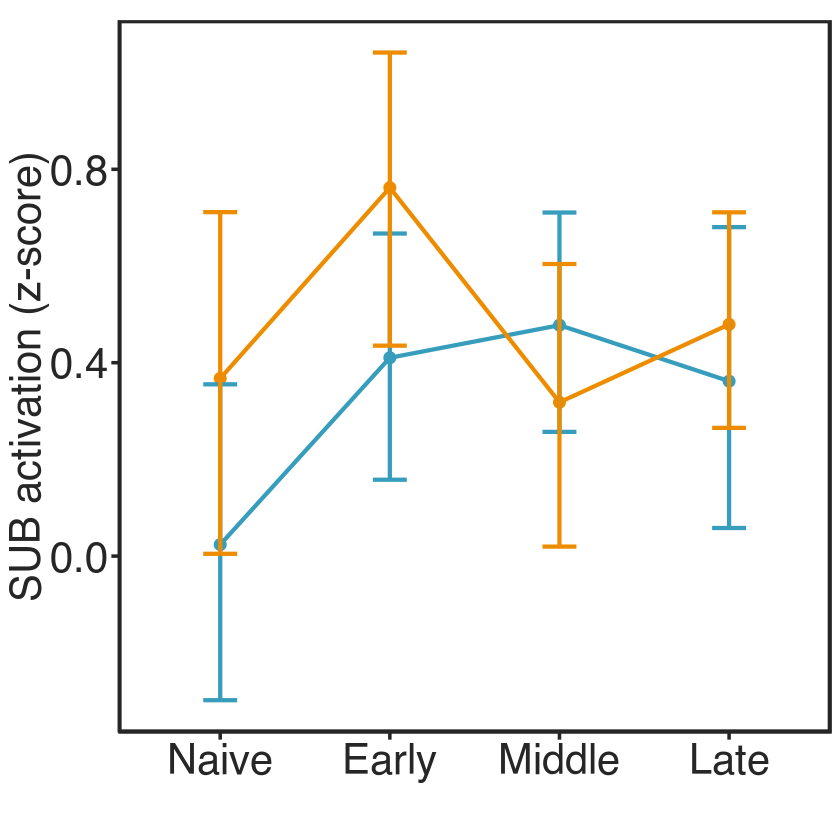

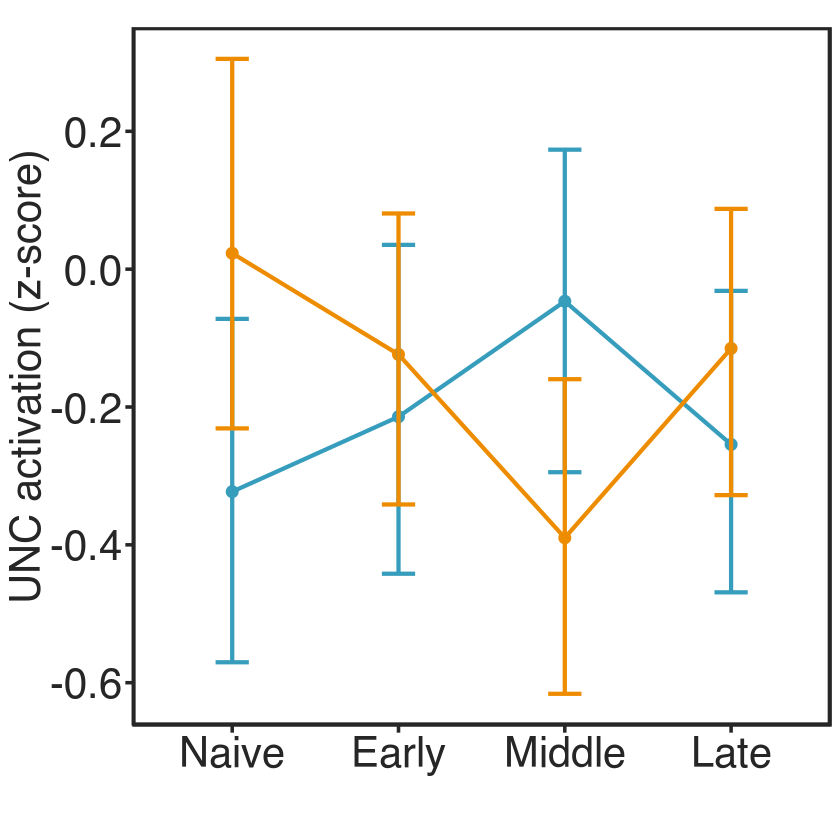

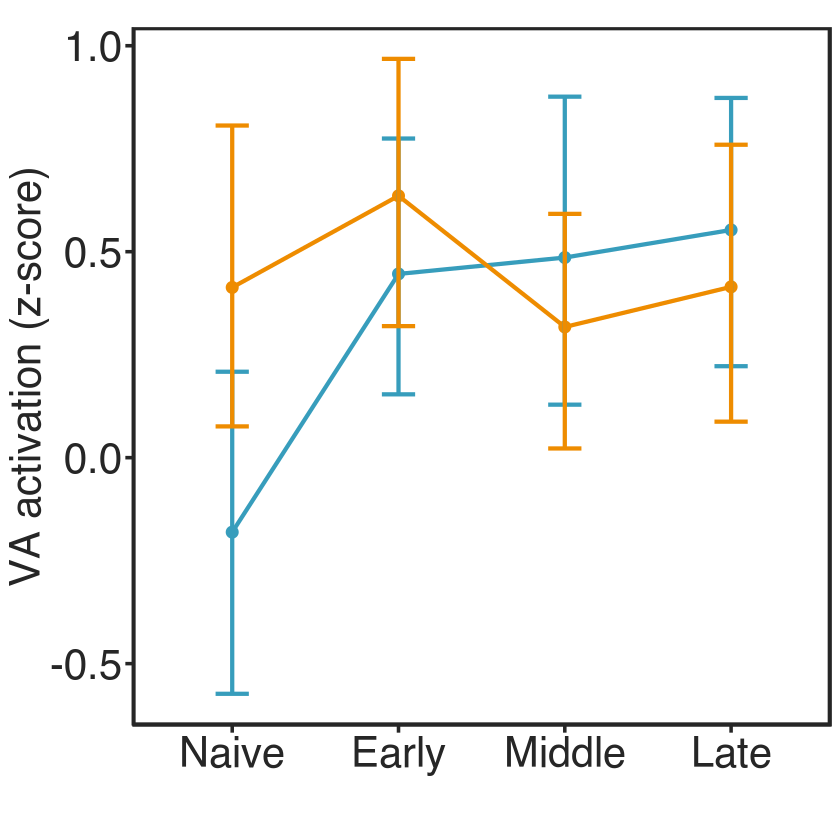

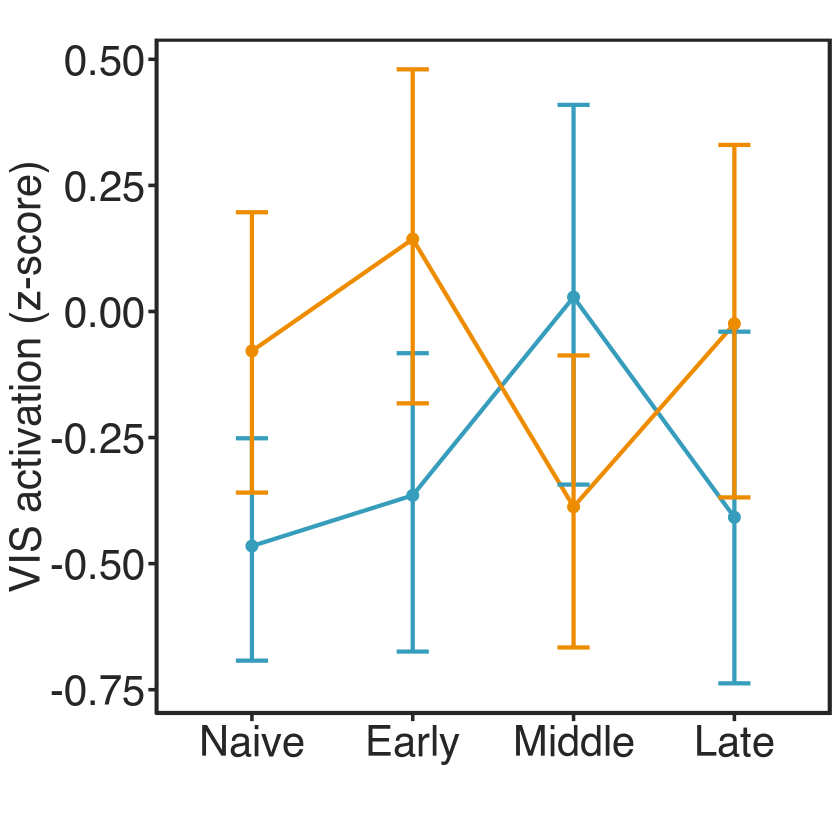

In [24]:
mlm_stats <- data.frame()
mlm_params <- data.frame()

for (i in 1:length(unique_networks)){
    net = glm %>% filter(Network == unique_networks[i])
    
    baseline <- lme(Activation ~ 1, random = ~ 1 |Subject/Session, data = net, method = 'ML',  control=lmeControl(returnObject=TRUE))#control = list(opt = "optim"))
    session <- update(baseline, .~. + Session)
    group <- update(session, .~. + Group)
    session_group <- update(group, .~. + Session:Group)
    
    #print(i)
    stats <- anova(baseline, session, group, session_group)
    #print(stats)
    
    params_interaction <- summary(session_group)
    
    vector_stats <- c(i,
                  stats['L.Ratio'][4,], 
                  stats['p-value'][4,])

    vector_params <- c(i, 
                       params_interaction$tTable[6,1], params_interaction$tTable[7,1], params_interaction$tTable[8,1], # betas
                       params_interaction$tTable[6,4], params_interaction$tTable[7,4], params_interaction$tTable[8,4], # ttests
                       params_interaction$tTable[6,5], params_interaction$tTable[7,5], params_interaction$tTable[8,5]) # pvals

    mlm_stats <- rbind(mlm_stats, vector_stats)
    mlm_params <- rbind(mlm_params, vector_params)

    p <- ggplot(net, aes(x = Session, y = Activation, col = Group)) +
    stat_summary(fun.y = mean, geom = 'point', size = 3) +
    stat_summary(fun.y = mean, geom = 'line', size = 1.2, aes(group = Group)) +
    stat_summary(fun.data = mean_cl_boot, geom = 'errorbar', width = 0.2, size = 1.2) +
    ylab(paste(unique_networks[i], 'activation (z-score)')) +    
    scale_colour_manual(values=c('#379dbc','#ee8c00')) +
    theme_training +
    theme(legend.position = "none") +
    xlab(' ') 
    print(p)         

     }

colnames(mlm_stats) <- c('i', 
                         'chi_interaction', 
                         'pval_interaction')
colnames(mlm_params) <- c('i',  
                          'beta12_interaction', 'beta13_interaction', 'beta14_interaction', 
                          'ttest12_interaction', 'ttest13_interaction', 'ttest14_interaction',
                          'pval12_interaction', 'pval13_interaction', 'pval14_interaction')

In [46]:
mlm_stats$pval_interaction_fdr <- p.adjust(mlm_stats$pval_interaction, method='fdr')
mlm_stats$net <- unique_networks[mlm_stats$i]
mlm_params$net <- unique_networks[mlm_params$i]

filter_stats <- mlm_stats %>% #filter(pval_interaction < 0.05) %>% 
    select(net, chi_interaction, pval_interaction, pval_interaction_fdr) 

filter_stats_all <- left_join(filter_stats, mlm_params[,2:11])
values <- format(round(filter_stats_all[,2:13],6), nsmall = 6)
cbind(filter_stats_all$net, values)

Joining, by = "net"


filter_stats_all$net,chi_interaction,pval_interaction,pval_interaction_fdr,beta12_interaction,beta13_interaction,beta14_interaction,ttest12_interaction,ttest13_interaction,ttest14_interaction,pval12_interaction,pval13_interaction,pval14_interaction
AU,2.794743,0.424366,0.424366,-0.172037,-0.479521,-0.015330,-0.517731,-1.443082,-0.046135,0.605599,0.151603,0.963279
CER,3.326098,0.344027,0.372696,0.325958,-0.428416,-0.012919,0.771316,-1.013765,-0.030570,0.442036,0.312735,0.975663
CO,4.233999,0.237280,0.298229,-0.420475,-0.572538,-0.163143,-1.356398,-1.846932,-0.526279,0.177519,0.067220,0.599665
DA,5.976738,0.112747,0.183215,0.184697,-0.636277,0.033757,0.500790,-1.725206,0.091530,0.617436,0.087065,0.927224
DM,10.220241,0.016784,0.060016,-0.750571,-0.759561,-0.779999,-2.554955,-2.585558,-2.655129,0.011870,0.010918,0.009004
FP,9.523477,0.023083,0.060016,-0.679019,-1.235466,-0.695647,-1.681509,-3.059484,-1.722686,0.095265,0.002735,0.087521
MEM,8.635576,0.034550,0.074858,-0.574095,-1.028740,-0.401063,-1.604609,-2.875349,-1.120979,0.111209,0.004776,0.264535
SAL,19.289622,0.000238,0.003096,-1.098080,-1.317647,-0.956718,-3.435695,-4.122681,-2.993399,0.000812,0.000069,0.003351
SOM,4.775350,0.189006,0.273008,-0.068707,-0.324227,0.381021,-0.207141,-0.977491,1.148714,0.836251,0.330293,0.252958
SUB,4.085796,0.252347,0.298229,0.007969,-0.503261,-0.226322,0.026838,-1.694766,-0.762156,0.978634,0.092713,0.447462
